<h1 align="center">SETTINGS</h1> 

<h2 align="center">STEP1: Geographical selection<h2>

In [1]:
import ipywidgets as ipywd
import base64
import hashlib
from typing import Callable
from IPython.display import HTML, display, FileLink


out = ipywd.Output()
display(out)

class DownloadButton(ipywd.Button):
    
    """Download button with dynamic content

    The content is generated using a callback when the button is clicked.
    """
    
    """This code is originally from 'ollik1', 
    posted in https://stackoverflow.com/questions/61708701/how-to-download-a-file-using-ipywidget-button
    
    on Aug 6, 2021
    """
    def __init__(self, filename: str, contents: Callable[[], str], **kwargs):
        super(DownloadButton, self).__init__(**kwargs)
        self.filename = filename
        self.contents = contents
        self.on_click(self.__on_click)

    def __on_click(self, b):
        contents: bytes = self.contents().encode('utf-8')
        b64 = base64.b64encode(contents)
        payload = b64.decode()
        digest = hashlib.md5(contents).hexdigest()  # bypass browser cache
        id = f'dl_{digest}'
        with out:
            display(HTML(f"""
<html>
<body>
<a id="{id}" download="{self.filename}" href="data:text/csv;base64,{payload}" download>
</a>

<script>
(function download() {{
document.getElementById('{id}').click();
}})()
</script>

</body>
</html>
"""))

Output()

In [5]:
# general imports
import ipyleaflet as ipylf
import ipywidgets as ipywd
from traitlets import link
import geopandas as gpd
import pandas as pd
from pathlib import Path
from shapely.geometry import Polygon, MultiPolygon, box, MultiLineString, LinearRing
from shapely.ops import unary_union
from io import BytesIO
import json
import yaml
global DEFAULT_CONFIG_FILE
global TOTAL_CONFIG

#local imports
# from Shapefile import subcountrymap
from emission_explorer.Shapefile import subcountrymap

###########################################################################################################
# Prepare configuration dictionary / file
###########################################################################################################
DEFAULT_CONFIG_FILE = Path('/home/esowc32/PROJECT/DATA/code_config.yml')
if not DEFAULT_CONFIG_FILE.exists():
    DEFAULT_CONFIG_FILE = Path(f"./code_config.yml")
    
TOTAL_CONFIG = {'geometry':'',
                'aggregating_operation':'',
                'specific_start_date':'',
                'specific_end_date' :'',
                'reference_start_date':'',
                'reference_end_date'  :'',
                'resolution'          :'',
                'variable'            :'',
                'plot_type'           :''}

def decompose_polygon_for_config(geom):
    """Extracts coords of a Polygon or Multipolygon and returns a list of x,y coords 
    (If MultiPolygon is a list of tuples, like:[(x,y),...]).
    INPUTS:
     - geom: Polygon or Multipoligon geometry
    OUTPUTS:
     - polxy: List of x,y of the decomposed Polygon (or list of tuples for Multipolygon).
     """
    if isinstance(geom, str):
        return '',''
    lines = geom.boundary
    if isinstance(lines, MultiLineString):
        mpolxy = []
        for pol in lines.geoms:
            mpolxy.append([list(r) for r in pol.xy])
    else:
        mpolxy = [list(r) for r in lines.xy]
    if isinstance(geom, MultiPolygon):
        polygon_type = 'multipolygon'
    else:
        polygon_type = 'singlepolygon'
        
    return mpolxy, polygon_type

def recompose_polygon_for_config(mpolxy, polygon_type):
    """From list of x,y coords (If MultiPolygon is a list of tuples, like:[(x,y),...]) 
    recompose a Polygon or Multipolygon.
    INPUTS:
     - polxy: List of x,y of the decomposed Polygon (or list of tuples for Multipolygon).
    OUTPUTS:
     - geom: Polygon or Multipoligon geometry
     """
    if (isinstance(mpolxy[0],tuple)) |(isinstance(mpolxy[0][0],list)):
        all_pol = []
        if polygon_type == 'multipolygon':
            for xx,yy in mpolxy:
                all_pol.append([(xi,yi) for xi,yi in zip(xx,yy)])
            geom = MultiPolygon([Polygon(s) for s in all_pol])
        elif polygon_type == 'singlepolygon':
            exterior = LinearRing([(xi,yi) for xi,yi in zip(mpolxy[0][0],mpolxy[0][1])])
            interiors = []
            for xx,yy in mpolxy[1::]:
                interiors.append(LinearRing([(xi,yi) for xi,yi in zip(xx,yy)]))
            geom = Polygon(exterior, interiors)
    else:
        geom = Polygon([(xi,yi) for xi,yi in zip(mpolxy[0],mpolxy[1])])
    return geom

def add_geometry(data = None, additional_geometry = None):
    if additional_geometry is None:
        return
    if data is None:
        if TOTAL_CONFIG:
            data = TOTAL_CONFIG.copy()
    else:
        data = data.copy()
    if isinstance(data['geometry'],str): # if it is a string it means it is empty
        new_geom = additional_geometry
    else:
        new_geom = unary_union([data['geometry'], additional_geometry])
    return new_geom

def chek_reply(reply):
    if (reply == 'y') | (reply == 'Y') | (reply is None):
        return True
    elif (reply == 'n') | (reply=='N'):
        return False
    else:
        print(f"\nYour reply was not clear, you inserted:'{reply}'.\nPlease insert 'Y' or press enter for YES, or 'n' for NO.\n")
        return None

    
def write_config(data = None, file = DEFAULT_CONFIG_FILE):
    if data is None:
        if TOTAL_CONFIG:
            data = TOTAL_CONFIG.copy()
    else:
        data = data.copy()
    answer = True
    if data['geometry']!='':
        data['geometry'], data['polygon_type'] = decompose_polygon_for_config(data['geometry'])
        
    # WRITE DOWN the config
    if answer:
        with open(file, 'w') as outfile:
            yaml.dump(data, outfile, default_flow_style=None)
    # activate download button
    download_shapefile() 

def read_config(config_file = None):    
    if config_file is None:
        config_file = DEFAULT_CONFIG_FILE
    with open(config_file) as src:
        dd = yaml.load(src,yaml.loader.FullLoader)
    if not isinstance(dd['geometry'], str):
        dd['geometry'] = recompose_polygon_for_config(dd['geometry'], dd['polygon_type'])
    return dd

if Path(DEFAULT_CONFIG_FILE).exists():
    TOTAL_CONFIG = read_config()
    set_default_values = True
    if TOTAL_CONFIG['geometry']=='':
        set_default_values = False
else:
    set_default_values = False

###########################################################################################################
# COMMON STYLES
###########################################################################################################
hover_style = {"fillColor": "#40E0D0", "fillOpacity": 0.5}
default_style = {
        "color": "black",
        "fillColor": "#366370",
        "opacity": 0.05,
        "weight": 1.9,
        "dashArray": "2",
        "fillOpacity": 0.6}
click_style = {"color": "#40E0D0",
            "fillColor": "red",#"#366370",
#             "opacity": 0.4,
            "weight": 3,
#             "dashArray": "3",
            "fillOpacity": 0.2}
###########################################################################################################
# Create Map
###########################################################################################################
m = ipylf.Map(center=(28.6019917, 70.9121356), zoom=2, basemap=ipylf.basemaps.Esri.WorldTopoMap, scroll_wheel_zoom = True)

def delete_all_additional_layers():
    dc.clear()
    for ll in m.layers:
        if (ll.name=='Selected country') | (ll.name=="Selected continent") | (ll.name=='old shp'):
            m.remove_layer(ll)
        elif ll.name == 'shp uploaded':
            m.remove_layer(ll)
            uploader.metadata.clear()
            uploader.data.clear()
            uploader.value.clear()
            uploader._counter = 0
    
###########################################################################################################
# Add shapefile countries
###########################################################################################################
# countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

url_to_download    = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_map_units.zip"#"https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_50m_admin_0_countries.zip"
# url_to_download    = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_map_subunits.zip"

# file_path_location = "/home/esowc32/PROJECT/DATA/shapefiles/PROCESSED_ne_110m_admin_0_map_units.zip"
# file_path_location = '/home/esowc32/PROJECT/DATA/shapefiles/PROCESSED2_ne_10m_admin_0_map_subunits.geojson' 
# file_path_location = '/home/esowc32/PROJECT/DATA/shapefiles/personalized_from_ne_110m_admin_0_map_units.geojson'
file_path_location = Path.cwd() / url_to_download.split('/')[-1]
sbcm = subcountrymap(file_path_location = file_path_location, url_to_download = url_to_download)
countries  = sbcm.shapefile.copy()
countries.index = countries.GEOUNIT
countries['name'] = countries.GEOUNIT
continent_shapefile = sbcm.continent_shapefile.copy()
all_shapes = pd.concat([countries, continent_shapefile])[['geometry','continent']]
# continent_shapefile.index = [f.upper() for f in continents.index]
# continents['continent']= [f.upper() for f in continents.index]

geo_data = ipylf.GeoData(
    geo_dataframe=countries,
    style=default_style,
    hover_style= hover_style,
    name="Countries")
m.add_layer(geo_data)

html =  ipywd.HTML("""Hover over a state""")
html.layout.margin = "0px 20px 20px 20px"
control =  ipylf.WidgetControl(widget=html, position="topright")
m.add_control(control)

def update_html(feature, **kwargs):
    html.value = """
        <h4><b>{}</b></h4>
        <h5>Continent: {}</h5>
    """.format(
        feature["properties"]["NAME_EN"],
        feature["properties"]["continent"],
    )
    
def underline_shape(feature, **kwargs):
    selected_layer = ipylf.GeoJSON(
                        data=feature,
                        name="Selected country",
                        hover_style=hover_style,
                        style=click_style)
    m.add_layer(selected_layer)
    # write it in config file
    new_geom = unary_union(list(gpd.GeoDataFrame.from_features([feature]).geometry.values))
    TOTAL_CONFIG.update({'geometry': add_geometry(additional_geometry=new_geom)})
    write_config(TOTAL_CONFIG, file = DEFAULT_CONFIG_FILE)
    
geo_data.on_click(underline_shape)
geo_data.on_hover(update_html)

# underline previous selection (if present in the configuraton file)
if set_default_values:
    geo_update = ipylf.GeoData(
        geo_dataframe=gpd.GeoDataFrame(geometry = [TOTAL_CONFIG['geometry']]),
        style=click_style,
        name="old shp"
    )
    m.add_layer(geo_update)

###########################################################################################################
# Add control buttons and additional commands
###########################################################################################################
## 1. Cancel shapes command
button_clear_selection = ipywd.Button(value=False,
                                      description='',
                                      disabled=False,
                                      button_style='', # 'success', 'info', 'warning', 'danger' or ''
                                      tooltip='Click to clear all the shapes',
                                      icon='trash', # (FontAwesome names without the `fa-` prefix)
                                      layout = ipywd.Layout(display='center',flex_flow='column',align_items='center',width='8mm')
                                     )
## 2. Upload shapes command
uploader = ipywd.FileUpload(multiple = True,
                            description='Upload shp',
                            style = {'description_width': 'initial'},
                            tooltip='select shapefile to load from local',
#                             layout = ipywd.Layout( display='center', flex_flow='column', align_items='center', width='18mm')
                           )

## 3. Download shapes command
db_shp = DownloadButton(filename='example.geojson', contents=lambda: None, 
                        disabled = True, 
                        description='Download shp',
                        style = {'description_width': 'initial'},
                        tooltip = 'download shp in GeoJSON format',
                        icon    = 'download', 
                       )

## 4. Refresher
refresher = ipywd.Button(value=False,
                       description='',
                       disabled=False,
                       button_style='', # 'success', 'info', 'warning', 'danger' or ''
                       tooltip='Click to refresh (dissolve shapes into one)',
                       icon='object-ungroup', # (FontAwesome names without the `fa-` prefix)
                       layout = ipywd.Layout(display='center',flex_flow='column',align_items='center',width='8mm')
                      )

def handle_draw(target, action, geo_json):
    if (action == 'created') | (action =='edited'):
        # write it in config file
        new_geom = unary_union(list(gpd.GeoDataFrame.from_features([geo_json]).geometry.values))
        TOTAL_CONFIG.update({'geometry': add_geometry(additional_geometry=new_geom)})
        write_config(TOTAL_CONFIG, file = DEFAULT_CONFIG_FILE)
    elif action == 'deleted':
        delete_all_additional_layers()
        # clear geometry from config
        TOTAL_CONFIG.update({'geometry':'','polygon_type':''})
        write_config(TOTAL_CONFIG, file = DEFAULT_CONFIG_FILE)
                
def clear_selection_click(event):
    delete_all_additional_layers()
    # clear geometry from config
    TOTAL_CONFIG.update({'geometry':'','polygon_type':''})
    write_config(TOTAL_CONFIG, file = DEFAULT_CONFIG_FILE)
            
def read_shape_from_uploader(event):
    """Load the shapefile selected into memory and show it in the map"""
    list_allowed_extensions = ['zip','geojson','shp','kml', 'kmz', 'gpkg']
    for kk,val in event.new.items():
        for kk1, val1 in val.items():
            if kk1 =='metadata':
                for kk2,val2 in val1.items():
                    if kk2=='name':
                        extension = val2.split('.')[-1]
                        # check the extension of the file
                        if extension in list_allowed_extensions:
                            # read the uploaded file
                            shp = gpd.read_file(BytesIO(val['content']))
#                             print(f'{val2} successfully loaded\n\n')
#                             uploader.disabled = True
                            # DRAW it on the map
                            geo_update = ipylf.GeoData(
                                geo_dataframe=shp,
                                style=click_style,
                                name="shp uploaded"
                            )
                            m.add_layer(geo_update)
                            # write it in config file
                            new_geom = unary_union(list(shp.geometry.values))
                            TOTAL_CONFIG.update({'geometry': add_geometry(additional_geometry=new_geom)})
                            write_config(TOTAL_CONFIG, file = DEFAULT_CONFIG_FILE)
                        else:
                            print(f"file {val2} with extension {extension} NOT allowed.\nPlease upload a file with one of the following extension {list_allowed_extensions}\n")
                            
def refresh_map(event):
    """Draw again the geometries but this time dissolved together"""
    delete_all_additional_layers()
    # DRAW it on the map
    geo_update = ipylf.GeoData(
        geo_dataframe=gpd.GeoDataFrame(geometry = [TOTAL_CONFIG['geometry']]),
        style=click_style,
        name="shp uploaded"
    )
    m.add_layer(geo_update)
    
def download_shapefile(filename_dwnd = None):
    if not isinstance(TOTAL_CONFIG['geometry'], str):
        tt = gpd.GeoDataFrame(geometry = [TOTAL_CONFIG['geometry']])
        #DOWNLOAD BUTTON APPEARS!
        if filename_dwnd is not None:
            db_shp.filename = filename_dwnd
        db_shp.contents = lambda: tt.to_json()
        db_shp.disabled = False
    else:
        db_shp.disabled = True
                            
dc = ipylf.DrawControl(edit=True,
                       remove=False, #True,
                       polygon = {"shapeOptions": click_style},
                       marker={},
                       rectangle={"shapeOptions": click_style},
                       polyline={},
                       circle={},
                       circlemarker={},
                      )
dc.on_draw(handle_draw)
m.add_control(dc)

## 1a. Refresher - draw
refresher.on_click(refresh_map)
rf = ipylf.WidgetControl(widget=refresher, position = 'topleft')
m.add_control(rf)

## 1b. Cancel shapes command - draw
button_clear_selection.on_click(clear_selection_click)
bsc = ipylf.WidgetControl(widget=button_clear_selection, position = 'topleft')
m.add_control(bsc)

## 2. Upload shapes command - draw
uploader.observe(read_shape_from_uploader, 'value')
up = ipylf.WidgetControl(widget=uploader, position = 'topright')
m.add_control(up)

## 3. Download shapes command - draw
dwnshp = ipylf.WidgetControl(widget=db_shp, position = 'topright')
m.add_control(dwnshp)

## 4. Fullscreen - draw
fs_control = ipylf.FullScreenControl()
m.add_control(fs_control)

###########################################################################################################
# Add dropdown menu with continents/countries
###########################################################################################################
cmbox1 = ipywd.Combobox(options=list(continent_shapefile.index),
                        placeholder='CONTINENT',
                        description=" ",
                        layout = {'width': 'max-content', 'margin' :'-1.5mm 1mm 1mm -22mm'}
#                         layout=ipywd.Layout(display='flex', flex_flow='column', align_items='initial', width='30mm')
                 )
list_countries = list(countries.index)
cmbox2 = ipywd.Combobox(options=list(list_countries),
                    placeholder='COUNTRY',
                    description=" ",
                    indent=False,
                    layout = {'width': 'max-content', 'margin' :'-1.5mm 1mm 1mm -22mm'}
#                     layout=ipywd.Layout(display='', flex = '1 1 10%', flex_flow='column', align_items='initial', width='30mm', height = '8mm')
                 )

def update_cmbox2_and_plot_cmbox1(continent):
    # UPDATE
    list_countries = list(countries[countries.continent==continent].index.values) # list(sbcm.shapefile[sbcm.shapefile.continent ==continent].GEOUNIT.values)
    if len(list_countries)>0:
        cmbox2.options = list_countries
        #PLOT
        #continent = continent.upper()
        rr = all_shapes[all_shapes.index == continent]
        if len(rr)>0:
            # DRAW it on the map
            geo_update = ipylf.GeoData(
                geo_dataframe=rr,
                style=click_style,
                name="Selected continent",
            )
            m.add_layer(geo_update)
            # write it in config file
            new_geom = unary_union(list(rr.geometry.values))
            TOTAL_CONFIG.update({'geometry': add_geometry(additional_geometry=new_geom)})
            write_config(TOTAL_CONFIG, file = DEFAULT_CONFIG_FILE)           

def remove_continents():
    """Function to Remove only the continent layer"""
    for ll in m.layers:
        if ll.name=="Selected continent":
            m.remove_layer(ll)
            
def plot_cmbox2(country):
    #extract selected country/continent
    rr = all_shapes[all_shapes.index == country]
    if len(rr)>0:
        # remove continent - for now we remove th entire shape
        clear_selection_click(None)
        # DRAW it on the map
        geo_update = ipylf.GeoData(
            geo_dataframe=rr,
            style=click_style,
            name="Selected country",
        )
        m.add_layer(geo_update)   
        # write it in config file
        new_geom = unary_union(list(rr.geometry.values))
        TOTAL_CONFIG.update({'geometry': add_geometry(additional_geometry=new_geom)})
        write_config(TOTAL_CONFIG, file = DEFAULT_CONFIG_FILE)  
        
inte1 = ipywd.interactive(update_cmbox2_and_plot_cmbox1, continent = cmbox1)
inte2 = ipywd.interactive(plot_cmbox2, country = cmbox2)
win_continents = ipylf.WidgetControl(widget=inte1, position = 'topright')
m.add_control(win_continents)
win_countries = ipylf.WidgetControl(widget=inte2, position = 'topright')
m.add_control(win_countries)

m

the file ne_110m_admin_0_map_units.zip already exists!


Map(center=[28.6019917, 70.9121356], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

<h2 align="center">STEP2: Specific period(s) of interest<h2>

In [3]:
from IPython.display import clear_output
import datetime as dt

In [4]:
# 2 Date Pickers
def save_datechange_end(value):
    if not isinstance(value.new,dict):
        TOTAL_CONFIG.update({'specific_end_date':f'{value.new:%d-%m-%Y}'})
        write_config(TOTAL_CONFIG,DEFAULT_CONFIG_FILE)

def save_datechange_start(value):
    if not isinstance(value.new,dict):
        TOTAL_CONFIG.update({'specific_start_date':f'{value.new:%d-%m-%Y}'})
        write_config(TOTAL_CONFIG,DEFAULT_CONFIG_FILE)

def save_dropdown1(value):
    if value.name =='label':
        TOTAL_CONFIG.update({'resolution':value.new})
        write_config(TOTAL_CONFIG,DEFAULT_CONFIG_FILE)
def save_dropdown2(value):
    if value.name =='label':
        TOTAL_CONFIG.update({'aggregating_operation':value.new})
        write_config(TOTAL_CONFIG, DEFAULT_CONFIG_FILE)
        
def create_line_pickers():
    # start_datepicker
    start_datepicker = ipywd.DatePicker(value = start_date, description = 'Start Date')
    start_datepicker.observe(save_datechange_start)
    # end_datepicker 
    end_datepicker   = ipywd.DatePicker(value = end_date  , description = 'End Date')
    end_datepicker.observe(save_datechange_end)
    return start_datepicker, end_datepicker
    
form_item_layout = ipywd.Layout(
#     align_items = 'center',
    display='start',
    flex_flow='row',
#     justify_content='center',
    width = 'initial',
)

temporal_resolution = ['daily',
#                        'weeskly',
                       'monthly']
aggregations = ['sum','mean',
#                 'median',
                'max','min', 'std']

today = dt.datetime.today() - dt.timedelta(days = 365)
if set_default_values:
    start_date = pd.to_datetime(TOTAL_CONFIG['specific_start_date'], format = '%d-%m-%Y')
    end_date   = pd.to_datetime(TOTAL_CONFIG['specific_end_date'], format = '%d-%m-%Y')
else:
    start_date = today - dt.timedelta(days = 365)
    end_date   = dt.datetime.today() - dt.timedelta(days = 365)
if TOTAL_CONFIG['resolution']!='':
    vv1 = TOTAL_CONFIG['resolution']
else:
    vv1 = None
    
if TOTAL_CONFIG['aggregating_operation']!='':
    vv2 = TOTAL_CONFIG['aggregating_operation']
else:
    vv2 = None
    
# resolution - dropdown widget
dropdown_widget1 = ipywd.Dropdown(options = temporal_resolution, description = 'Resolution', value = vv1)
dropdown_widget1.observe(save_dropdown1)
# aggregation - dropdown widget
dropdown_widget2 = ipywd.Dropdown(options = aggregations, description = 'Aggregating Operation', value = vv2)
dropdown_widget2.observe(save_dropdown2)
# datepickers
start_datepicker, end_datepicker = create_line_pickers()
# PLUS button
tb_plus = ipywd.ToggleButton(value=False, disabled=False, description = ' ', 
                                  tootltip = 'press to add more references',
                                  icon = 'plus',
                                  layout={'width': 'initial','description_width': 'initial', 'height':'60 px'})

def add_minus_button():
    def remove_line(event):  
        print('eee')
        #     if tb_minus.value:
        with out:
            clear_output()
    #             add_line = ipywd.HBox([start_p, end_p, tb_minus])
    #         display(add_line)
    #     tb_minus.value = False
        return None
    tb_minus = ipywd.ToggleButton(value=False,disabled=False, description = ' ', tootltip = 'press to add more references', 
                          icon = 'minus',layout={'width': 'initial','description_width': 'initial', 'height':'60 px'})
    tb_minus.observe(remove_line, names = 'value')  
    return tb_minus


def repeat_line(event):
    if tb_plus.value:
        start_p, end_p = create_line_pickers()
#         with out:
        tb_minus = add_minus_button()
        add_line = ipywd.HBox([start_p, end_p, tb_minus])
#         display(add_line)
        with out:
            display(add_line)
    tb_plus.value = False
    return None

tb_plus.observe(repeat_line, names = 'value')  

vbox1 = ipywd.HBox([dropdown_widget1, dropdown_widget2], layout=form_item_layout)
vbox2 = ipywd.HBox([start_datepicker, end_datepicker])#, tb_plus]), layout=form_item_layout)

# vbox1.observe(print_change)
table = ipywd.VBox([vbox1, vbox2])#, layout=form_item_layout)
display(table)
out = ipywd.Output()
display(out)

Output()

<h2 align="center">STEP3 (optional): Reference period<h2>

In [5]:
class reference_period_table():
    def __init__(self, reference_start: str = None, reference_end : str = None):
        self.reference_start = pd.Timestamp(reference_start)
        self.reference_end   = pd.Timestamp(reference_end)
        self.form_item_layout = ipywd.Layout(
                                #     align_items = 'center',
                                display='start',
                                flex_flow='row',
                                #     justify_content='center',
                                width = 'initial',
                                    )
        self.tables = []
    def make_table(self):
        # start_datepicker
        self.start_datepicker = ipywd.DatePicker(value = self.reference_start, description = 'Start Date')
        self.start_datepicker.observe(self.save_datechange_start_ref)
        # end_datepicker 
        self.end_datepicker   = ipywd.DatePicker(value = self.reference_end, description = 'End Date')
        self.end_datepicker.observe(self.save_datechange_end_ref)
#         # PLUS button
#         self.tb_plus = ipywd.ToggleButton(value=False,disabled=False, description = ' ', tootltip = 'press to add more references', 
#                                   icon = 'plus',
#                  layout={'width': 'initial','description_width': 'initial', 'height':'60 px'})
#         self.tb_plus.observe(self.repetition_reference, names = 'value')  
        # ENTIRE TABLE
        self.tables.append(ipywd.HBox([self.start_datepicker, self.end_datepicker,
#                                             self.tb_plus
                                           ],
                                     layout=self.form_item_layout))
#         display(self.tables[-1])
        return self.tables
        
    @staticmethod
    def save_datechange_end_ref(value):
    #     cc = event.new
        if not isinstance(value.new,dict):
    #         print(value.new, type(value.new))
            if value.new is not None:
                TOTAL_CONFIG.update({'reference_end_date':f'{value.new:%d-%m-%Y}'})
            else:
                TOTAL_CONFIG.update({'reference_end_date':''})
            write_config(TOTAL_CONFIG,DEFAULT_CONFIG_FILE)
    @staticmethod
    def save_datechange_start_ref(value):
    #     cc = event.new
        if not isinstance(value.new,dict):
    #         print(value.new, type(value.new))
            if value.new is not None:
                TOTAL_CONFIG.update({'reference_start_date':f'{value.new:%d-%m-%Y}'})
            else:
                TOTAL_CONFIG.update({'reference_start_date':''})
            write_config(TOTAL_CONFIG,DEFAULT_CONFIG_FILE)
    @staticmethod       
    def repetition_reference(event):
#         print(event)
        tb_plus.value = False
        pt2 = reference_period_table()
        tb2 = pt2.make_table()
        display(pt2.tables[-1])
        tb2.value = False
#         display(tb2)
        return None
        
# reference_start_date
# reference_end_date

# # start_datepicker
# start_datepicker = ipywd.DatePicker(value = start_date, description = 'Start Date')
# start_datepicker.observe(save_datechange_start_ref)
# # end_datepicker 
# end_datepicker   = ipywd.DatePicker(value = end_date  , description = 'End Date')
# end_datepicker.observe(save_datechange_end_ref)

# table = ipywd.HBox([start_datepicker, end_datepicker], layout=form_item_layout)
# table

# tb_plus
pt = reference_period_table(reference_start = TOTAL_CONFIG['reference_start_date'], reference_end = TOTAL_CONFIG['reference_end_date'])
tb_plus = pt.make_table()
display(pt.tables[-1])

C:\Users\gio1r\.conda\envs\test2_todelete\lib\site-packages\jupyter_client\session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


<h2 align="center">STEP4: Variables<h2>

In [6]:
# dropdown list
# multiple selection (optional)
table_database = {
    'Wildfire flux of Carbon Dioxide'           :('co2fire'  , 'gfas_co2fire_data',  'kg/day',),                   
    'Wildfire flux of Carbon Monoxide'          :('cofire'   , 'gfas_cofire_data',   'kg/day',),                                                        
    'Wildfire flux of Methane'                  :('ch4fire'  , 'gfas_ch4fire_data',  'kg/day',),                                               
    'Wildfire flux of Nitrogen Oxides NOx'      :('noxfire'  , 'gfas_noxfire_data',  'kg/day',),                              
    'Wildfire flux of Particulate Matter PM2.5' :('pm2p5fire', 'gfas_pm2p5fire_data','kg/day',),                                  
    'Wildfire flux of Total Particulate Matter' :('tpmfire'  , 'gfas_tpmfire_data',  'kg/day',),                      
    'Wildfire flux of Total Carbon in Aerosols' :('tcfire'   , 'gfas_tcfire_data',   'kg/day',),                               
    'Wildfire flux of Organic Carbon'           :('ocfire'   , 'gfas_ocfire_data',   'kg/day',),               
    'Wildfire flux of Black Carbon'             :('bcfire'   , 'gfas_bcfire_data',   'kg/day',),                              
    'Wildfire overall flux of burnt Carbon'     :('cfire'    , 'gfas_cfire_data',    'kg/day',),                                   
    'Wildfire radiative power'                  :('frpfire'  , 'gfas_frpfire_data',  'W',),                    
    'Wildfire Flux of Ammonia (NH3)'            :('nh3fire'  , 'gfas_nh3fire_data',  'kg/day',)
}  

# dropdown widget
if TOTAL_CONFIG['variable']=='':
    start_variable = None
else:
    start_variable = TOTAL_CONFIG['variable']
    
variables = []
for name, data in table_database.items():
    variables.append((f'{name} ({data[0]}) [{data[2]}]',name))   #= ['Fire Radiative Power (frpfire)','CO2 radiation (co2fire)']
# variables.append(('Fire Radiative Power (frpfire)','Fire Radiative Power (frpfire)'))
dropdown_widget = ipywd.Dropdown(options = variables, description = 'Variable(s)',
                                 value = start_variable,
                                )
def save_variable(value):
    if value.name =='value':
        TOTAL_CONFIG.update({'variable':dropdown_widget.value})
        write_config(TOTAL_CONFIG, DEFAULT_CONFIG_FILE)


dropdown_widget.observe(save_variable)
dropdown_widget

Dropdown(description='Variable(s)', options=(('Wildfire flux of Carbon Dioxide (co2fire) [kg/day]', 'Wildfire …

<h2 align="center">STEP5: PLOTS<h2>

In [7]:
%matplotlib widget

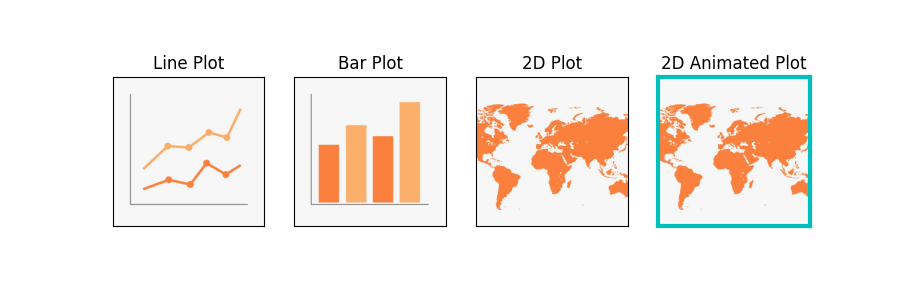

In [8]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Button

image_files=list((Path.cwd()/'images_gui').glob('*'))

plot_types = ['Line Plot', 'Bar Plot', '2D Plot', '2D Animated Plot']

fig1 = plt.imread( [f for f in image_files if 'Line' in f.name][0]  )
fig2 = plt.imread( [f for f in image_files if 'Bar' in f.name][0]   )
fig3 = plt.imread( [f for f in image_files if 'World' in f.name][0] )

figtot, axs = plt.subplots(1,4,figsize = (9,3))
# [ax.axis('off') for ax in axs]
# ICON_PLAY =  plt.imread('https://i.stack.imgur.com/ySW6o.png')
# ICON_PAUSE = plt.imread("https://i.stack.imgur.com/tTa3H.png")
# button_axes = plt.axes([0.3, 0.3, 0.4, 0.4])
button1  = Button(axs[0], '', image=fig1)
button2  = Button(axs[1], '', image=fig2)
button3  = Button(axs[2], '', image=fig3[:,200:864,:])
button4  = Button(axs[3], '', image=fig3[:,200:864,:])

t1 = axs[0].set_title(plot_types[0])
t2 = axs[1].set_title(plot_types[1])
t3 = axs[2].set_title(plot_types[2])
t4 = axs[3].set_title(plot_types[3])

def select_box(axis):
    TOTAL_CONFIG.update({'plot_type':axis.get_title()})
    write_config(TOTAL_CONFIG, file = DEFAULT_CONFIG_FILE)
    [axis.spines[l].set_color('c') for l in axis.spines]
    [axis.spines[l].set_linewidth(3) for l in axis.spines]

def unselect_box(axis):
    [axis.spines[l].set_color('k') for l in axis.spines]
    [axis.spines[l].set_linewidth(0.8) for l in axis.spines]

def onclick_b1(event):
    select_box(axs[0])
    unselect_box(axs[1])
    unselect_box(axs[2])
    unselect_box(axs[3])
    figtot.canvas.draw_idle()
def onclick_b2(event):
    unselect_box(axs[0])
    select_box(axs[1])
    unselect_box(axs[2])
    unselect_box(axs[3])
    figtot.canvas.draw_idle()
def onclick_b3(event):
    unselect_box(axs[0])
    unselect_box(axs[1])
    select_box(axs[2])
    unselect_box(axs[3])
    figtot.canvas.draw_idle()
def onclick_b4(event):
    unselect_box(axs[0])
    unselect_box(axs[1])
    unselect_box(axs[2])
    select_box(axs[3])
    figtot.canvas.draw_idle()
    
    
nn = [it for it, f in enumerate(plot_types) if f==TOTAL_CONFIG['plot_type']]
if nn:
    select_box(axs[nn[0]])

button1.on_clicked(onclick_b1)
button2.on_clicked(onclick_b2)
button3.on_clicked(onclick_b3)
button4.on_clicked(onclick_b4)
None
# def play(event):
#     button_axes.images[0].set_data(ICON_PAUSE)
#     figtot.canvas.draw_idle()

# button_axes = plt.axes([0.3, 0.3, 0.4, 0.4])
# start_button = Button(button_axes, '', image=ICON_PLAY)
# start_button.on_clicked(play)
# plt.show()

<h1 align="center">RESULTS<h1>

In [9]:
import time
import sys
from matplotlib.dates import DateFormatter
import base64
import hashlib
from typing import Callable
from IPython.display import HTML, display, FileLink
from matplotlib.animation import FuncAnimation
import mapclassify as mc
import numpy as np
from IPython import display as ipydisplay

# Local imports
# sys.path.append("..")
# from PostGIS.GfasActivityReader import GfasActivityReader
from emission_explorer.GfasActivityReader import GfasActivityReader

out = ipywd.Output()
display(out)

class DownloadButton(ipywd.Button):
    
    """Download button with dynamic content

    The content is generated using a callback when the button is clicked.
    """
    
    """This code is originally from 'ollik1', 
    posted in https://stackoverflow.com/questions/61708701/how-to-download-a-file-using-ipywidget-button
    
    on Aug 6, 2021
    """
    def __init__(self, filename: str, contents: Callable[[], str], **kwargs):
        super(DownloadButton, self).__init__(**kwargs)
        self.filename = filename
        self.contents = contents
        self.on_click(self.__on_click)

    def __on_click(self, b):
        contents: bytes = self.contents().encode('utf-8')
        b64 = base64.b64encode(contents)
        payload = b64.decode()
        digest = hashlib.md5(contents).hexdigest()  # bypass browser cache
        id = f'dl_{digest}'
#         text22.value = f"\t DOWNLOADING!"
        with out:
            display(HTML(f"""
<html>
<body>
<a id="{id}" download="{self.filename}" href="data:text/csv;base64,{payload}" download>
</a>

<script>
(function download() {{
document.getElementById('{id}').click();
}})()
</script>

</body>
</html>
"""))

Output()

In [10]:
# global fig_sol, ax_sol
def clear_line(n=1):
    LINE_UP = '\033[1A'
    LINE_CLEAR = '\x1b[2K'
    for i in range(n):
        print(LINE_UP, end=LINE_CLEAR)

def confirm_selections(conf):
    """Check if all the essential fields in the configuration files are presents, otherwise throws a WARNING and stops computation."""
    dictionary_sessions = {
        'geometry': 'STEP1: Geographical selection',
        'specific_start_date' : 'STEP2: Specific period(s) of interest',
        'specific_end_date': 'STEP2: Specific period(s) of interest',
        'resolution': 'STEP2: Specific period(s) of interest',
        'variable':'STEP4: Variables', 
        'plot_type':'STEP5: PLOTS',
    }
    for tt,key in enumerate(conf.keys()):
            if conf[key] == '':
                if key in dictionary_sessions.keys():
                    sect = dictionary_sessions[key]
                    clear_line(200)
                    text.value = f"The field '{key}' is missing and it is necessary! please fill it in in section '{sect}' before continuing..."
                    return None
    return True

###################################################################################
###########                   PLOTS FUNCTIONS
###################################################################################

def plot_lineplot(data, ax):
    """Creates a lineplot with quantiles (from 0 to 100 with different steps) for each day of the year."""
    ddoy = data.groupby(data.index.dayofyear)
    quantiles = [0, 0.1, 0.25, .5, .75, 0.9, 1]
    for p in quantiles:
        d = ddoy.quantile(p)
        d.rename(columns={c: f'p={p}%-{c}' for c in d.columns}, inplace=True)
        d.index = [pd.to_datetime(f'2000{f:03d}', format = '%Y%j') for f in d.index]
        if quantiles.index(p) == 0:
            ax = d.plot(ax=ax)
        else:
            d.plot(ax=ax)
    dfmt = DateFormatter("%d-%b") # proper formatting Year-month-day
    ax.xaxis.set_major_formatter(dfmt)
    return ax

def plot_barplot(datanew, ax, resolution = TOTAL_CONFIG['resolution'], title = None):
    """Creates the barplot using 'datanew' in the specified axis 'ax'. 'resolution' is used to adapt the xaxis ticks."""
    if title is None:
        title = f"{TOTAL_CONFIG['variable']}"
    
    datanew.plot.bar(ax=ax, color = ['#A9A9A9','#B22222','y'])
    if resolution =='daily': # for daily data
        ax.set_xticklabels([f'{pd.Timestamp(f.get_text()).day:02d}-{pd.Timestamp(f.get_text()).month_name()}' for f in ax.get_xticklabels()])
        ax.locator_params(axis='x', nbins=12)
    else:
        ax.set_xticklabels([f'{pd.Timestamp(f.get_text()).month_name()}' for f in ax.get_xticklabels()])
    
    ax.set_title(title)    
    return ax

def plot2dbackground(ax):
    """Function to create the background of the 2d plot, with boarders of the countries and the highlighted area of interest."""
    bb = TOTAL_CONFIG['geometry']
    elem = gpd.GeoDataFrame(geometry = [bb], crs = 'EPSG:4326')
    ax = elem.boundary.plot(ax=ax, zorder = 0, color = 'grey', alpha = 1, lw = 0.7)
    ax = all_shapes.boundary.plot(ax=ax, color = 'grey', alpha =0.8, lw = 0.2)
    
    #extract limits
    ll = max(bb.bounds[2]-bb.bounds[0], bb.bounds[3]-bb.bounds[1])
    ## new squared geometry
    bbnew = box(bb.centroid.x-ll/2,bb.centroid.y-ll/2,bb.centroid.x+ll/2,bb.centroid.y+ll/2)
    xmin,ymin,xmax, ymax = bbnew.buffer(2).bounds
    ## set limits new
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    return ax

def plot_2dplot(datanew, ax, operation = 'sum', title = None, background = True, vmin=None, vmax=None, scheme='quantiles', classification_kwds=None):
    """Creates the 2D plot using the datas in 'datanew' """
    
    table_name = table_database[TOTAL_CONFIG['variable']][1]
    unit_meas  = table_database[TOTAL_CONFIG['variable']][2]
    name_ext   = TOTAL_CONFIG['variable']
    
    column_name_to_plot = datanew.columns[0]#f"{table_name.replace('_data','')}_{operation}"
    st, en = datanew.columns[0].split(' - ')
    st = st.split('_')[-1]
    if title is None:
        title = f"{name_ext}\n '{operation}' from {st} to {en}"
    legend_name = f"{table_name} [{unit_meas.replace('/day','')}]"
    
    if background:
        ax = plot2dbackground(ax)
        
    datanew.plot(column_name_to_plot,
                 ax=ax, 
                 cmap='OrRd',#'RdYlBu_r', 
                 vmin = vmin, vmax = vmax,
                 legend=True, scheme=scheme,
                 k= 10,
                 classification_kwds=classification_kwds,
                 legend_kwds = dict(
                     loc='center left', 
                     bbox_to_anchor=(1, 0.5),
                     title = legend_name, fmt = '{:.1e}')
                  )
    ax.set_title(title)
    fig = ax.get_figure()
    fig.tight_layout()
    # correction: remove for first element of the legend which is always [-inf, 0]
    return ax

def animate_plot_2dplot(operator = 'sum'):
    """Create an animation of the defined area"""
    all_days = extract_data(start_date = TOTAL_CONFIG['specific_start_date'], 
                            end_date = TOTAL_CONFIG['specific_end_date'], 
                            function_to_aggregate = operator,
                            keep_separate_dates = True, 
                            reference_period = False)
    scheme="User_Defined"
    val_min = all_days.iloc[:,0].min()
    val_max = all_days.iloc[:,0].max()
    classification_kwds=dict(bins=mc.Quantiles(all_days.iloc[:,0]).bins)
    
    indd = []
    for days in all_days.index.get_level_values(0).drop_duplicates():
        indd.append(days)
    pp = all_days.loc[[indd[0]],:]
    
    fig_sol, ax_sol = plt.subplots(figsize = (8,5))
    fig_sol.tight_layout()
    
    plot_2dplot(pp, ax_sol, title = f"{TOTAL_CONFIG['variable']}\n{days.day:02d}-{days.month:02d}-{days.year}",
                scheme=scheme, classification_kwds=classification_kwds,
                )
    def animate(frame_num):
        #         text.value = f'2. Creating video {frame_num+1}/{len(indd)} completed'
        days = indd[frame_num]
        plot_2dplot(all_days.loc[days,:],
                    ax=ax_sol,
                    title = f"{TOTAL_CONFIG['variable']}\n{days.day:02d}-{days.month:02d}-{days.year}", 
                    background=False,scheme=scheme, classification_kwds=classification_kwds,
                   )
        return ax_sol
    plt.close()
    anim = FuncAnimation(fig_sol, animate, frames=len(indd), interval=250)
    video = anim.to_html5_video()
    with out2:
        html = ipydisplay.HTML(video)
        ipydisplay.display(html, clear= True )
    return all_days

def select_plot_type(plot_type, data_to_plot, operation = 'sum'):
    """Creates the plot"""
    fig_sol, ax_sol = plt.subplots(figsize = (8,5))
    fig_sol.tight_layout()
    if plot_type == 'Line Plot':
        ax_sol = plot_lineplot(data_to_plot, ax_sol)
    elif plot_type == 'Bar Plot':
        ax_sol = plot_barplot(data_to_plot, ax_sol, resolution = TOTAL_CONFIG['resolution'])
    elif plot_type == '2D Plot':
        ax_sol = plot_2dplot(data_to_plot, ax_sol, operation = operation)
    else:
        ax_sol.set_title('The plot type in the configuration file was not CLEAR!', fontsize = 20)
    return fig_sol, ax_sol

def plot_config(all_data, operation = 'sum'):     

    if all_data.empty:
        text.value = '3. NO DATA FOUND FOR THE SELECTED REGION'
        return 
    text.value = '2. Creating Plot'
    fig, ax = select_plot_type(TOTAL_CONFIG['plot_type'], all_data, operation = operation)
    text.value = f"3. FINISHED PLOT!"
    
    return fig, ax 

###################################################################################
###########                   DATA QUERY FUNCTIONS
###################################################################################

def adapt_resolution(data_or, resolution = TOTAL_CONFIG['resolution']):
    """Function to resample the data at different resolutions ('daily' or 'monthly' for now)"""
    if resolution =='monthly':
        datanew = data_or.groupby([data_or.index.month,data_or.index.year]).mean()
        datanew.index = [pd.Timestamp(day = 1, month = f[0], year = f[1]) for f in datanew.index.values]
        datanew = datanew.sort_index()

    if resolution=='weekly':
        datanew = data_or.groupby(data_or.index.strftime('%Y-%U')).mean()
        datanew.index = [pd.to_datetime(f'{f[0:4]}-{(int(f[-2::]))*7+1}', format='%Y-%j') for f in datanew.index]
        datanew = datanew.sort_index()
    
    if resolution=='daily':
        datanew = data_or # they are already at a daily resolution
    return datanew

def check_data(index, reference_period = False):
    """Function that checks the start and end date of both specific and refernce period and adapts
    the temporal extension of the data to a subsample where the day/month of these two periods intersects."""
    if reference_period:
        st_string, end_string = 'reference_start_date', 'reference_end_date'
    else:
        st_string, end_string = 'specific_start_date', 'specific_end_date'
    ########## CHECK on extension of the data
    if index.values[0]!= pd.to_datetime(TOTAL_CONFIG[st_string], format = '%d-%m-%Y'):
        # modify start date according to available data
        pp = pd.Timestamp(index.values[0])
        old_d = TOTAL_CONFIG[st_string]
        TOTAL_CONFIG[st_string] = f"{pp:%d-%m-%Y}"
        print(f"changing {st_string} from {old_d} to {pp:%d-%m-%Y}")
    if index.values[-1]!= pd.to_datetime(TOTAL_CONFIG[end_string], format = '%d-%m-%Y'):
        # modify end date according to available data
        pp = pd.Timestamp(index.values[-1])
        old_d = TOTAL_CONFIG[end_string]
        TOTAL_CONFIG[end_string] = f"{pp:%d-%m-%Y}"
        print(f"changing {end_string} from {old_d} to {pp:%d-%m-%Y}")
    write_config()

def extract_data(adapt_resolution_option = True, 
                 start_date = TOTAL_CONFIG['specific_start_date'], 
                 end_date = TOTAL_CONFIG['specific_end_date'], 
                 function_to_aggregate = 'sum', 
                 keep_separate_dates = False,
                 reference_period = False):
    """Main Function that queries the POSTGIS database based on the type of plot chosen."""
    if confirm_selections(TOTAL_CONFIG): #checks if config is complete
        table_name = table_database[TOTAL_CONFIG['variable']][1]
        db = GfasActivityReader() #starts the connection with the database
        polygon = TOTAL_CONFIG['geometry']
        minx, miny,maxx, maxy = polygon.bounds
        start_date = dt.datetime.strptime(start_date,'%d-%m-%Y')
        end_date   = dt.datetime.strptime(end_date,'%d-%m-%Y')
        if start_date>end_date:
            raise ValueError(f'INVALID SPECIFIC PERIOD: start after end. Start={start_date:%d-%m-%Y}, End={end_date:%d-%m-%Y}')
        
        if '2D' in TOTAL_CONFIG['plot_type']: # index are now 'clust' 'x_y' info
            data_or, data = db.extract_data_polygon(table_name, start_date, end_date, polygon,
                                                    agg_operations = [function_to_aggregate],
                                                    resolution = 0.1, keep_separate_dates = keep_separate_dates)
            if data.empty:
                return data
            adapt_resolution_option = False
#             check_data(data_or.index, reference_period = False)
            start_date, end_date   = data_or.index[0], data_or.index[-1]
        else:
            data = db.extract_data2(start_date, end_date, polygon, table_name, agg_operation = function_to_aggregate)
            if data.empty:
                return data
#             check_data(data.index, reference_period = reference_period)
            start_date, end_date   = data.index[0], data.index[-1]
            months_abbreviations = {'January':'Jan', 'February': 'Feb', 'March': 'Mar', 'April': 'Apr', 'May':   'May', 'June':  'Jun', 'July' : 'Jul', 'August':'Aug', 'September': 'Sept', 'October'  : 'Oct', 'November' : 'Nov', 'December' : 'Dec'}
            # AVERAGE SAME DAY OF DIFFERENT YEAR TOGETHER
            if not keep_separate_dates:
                data = data.groupby([f'{dd:02d}-{mm:02d}' for dd, mm in zip(data.index.day, data.index.month)]).mean()
                data.index = [pd.Timestamp(year = 2220, day = int(f[0:2]), month = int(f[3::])) for f in data.index]
                data.index = pd.DatetimeIndex(data.index)
        data.columns = [f"{start_date.day:02d}/{start_date.month:02d}/{start_date.year} - {end_date.day:02d}/{end_date.month:02d}/{end_date.year}" if (f!='geometry') else 'geometry' for f in data.columns]
        
        if adapt_resolution_option:
            return adapt_resolution(data.copy(), resolution = TOTAL_CONFIG['resolution'])
        else:
            return data.copy()
        
def check_extraction(kws_extraction):
    try:
        return extract_data(**kws_extraction)
    except Exception as e:
        #it means there is an error
        text.value = e.args[0]
        raise e
        return None

tb = ipywd.ToggleButton(value=False,disabled=False, description = 'PRESS TO CREATE PLOT', tootltip = 'press to compute the plot', icon = 'arrow-circle-right',
                 layout={'width': 'initial','description_width': 'initial', 'height':'60 px'})
out2   = ipywd.Output(layout={'border': '1px solid black'})

def selection(event):
    """Main orchestrator: when button is pushed request the data query, plots teh data and prepares the csv file to download."""
    if event.new:
        try:
            TOTAL_CONFIG = read_config()
            if confirm_selections(TOTAL_CONFIG):
                aggregating_operation = TOTAL_CONFIG['aggregating_operation']
                var = table_database[TOTAL_CONFIG['variable']][1] 

                if TOTAL_CONFIG['plot_type'] =='2D Animated Plot':
                    text.value = '1. Extracting DATA'
                    data_to_save = animate_plot_2dplot(operator = aggregating_operation)
                    text.value = '2. Video Created!'
                    filename_dwnd = f"everydayay_data_{var}__S{TOTAL_CONFIG['specific_start_date'].replace('-','')}-{TOTAL_CONFIG['specific_end_date'].replace('-','')}.csv"
                else:
                    text.value = '1. Extracting DATA'
                    data_to_plot = check_extraction(dict(start_date = TOTAL_CONFIG['specific_start_date'],
                                                end_date = TOTAL_CONFIG['specific_end_date'],
                                                function_to_aggregate = aggregating_operation))
                    filename_dwnd = f"data_{var}__S{TOTAL_CONFIG['specific_start_date'].replace('-','')}-{TOTAL_CONFIG['specific_end_date'].replace('-','')}.csv"
                    #ADD reference period
                    if (TOTAL_CONFIG['reference_start_date']!='') & (TOTAL_CONFIG['reference_end_date']!='') & (TOTAL_CONFIG['plot_type'] !='2D Plot'):
                        text.value = '1. Extracting REFERENCE DATA'
                        reference_data = check_extraction(dict(start_date = TOTAL_CONFIG['reference_start_date'],
                                                      end_date = TOTAL_CONFIG['reference_end_date'],
                                                      reference_period = True,
                                                      function_to_aggregate = aggregating_operation
                                                     ))
                        reference_data.rename(columns={c: f'REFERENCE: {c}' for c in reference_data.columns}, inplace=True)
                        data_to_plot   = pd.merge( reference_data,data_to_plot, left_index=True, right_index=True)
                        filename_dwnd = filename_dwnd.replace(".csv",f"__R{TOTAL_CONFIG['reference_start_date'].replace('-','')}-{TOTAL_CONFIG['reference_end_date'].replace('-','')}.csv")

                    data_to_plot   = data_to_plot.sort_index()
                    fig_sol, ax_sol = plot_config(data_to_plot, operation = aggregating_operation)

                    data_to_save   = data_to_plot.copy()
                    if TOTAL_CONFIG['plot_type'] !='2D Plot':
                        data_to_save.index = [f"{dd.day:02d}-{dd.strftime('%b')}" for dd in data_to_save.index]
                    with out2:
                        fig_sol.tight_layout()
                        ipydisplay.display(fig_sol.canvas, clear= True)

                #DOWNLOAD BUTTON APPEARS!
                db.filename = filename_dwnd
                db.contents = lambda: data_to_save.to_csv()
                db.disabled = False
                time.sleep(2)            
                tb.value = False
        
        except Exception as e:
            with out2:
                raise e
                
    else:
        text.value = 'Change config and press again for another plot'


tb.observe(selection, names = 'value') 
db = DownloadButton(filename='empty.csv', contents=lambda: 'empty', disabled = True, 
                    description='Download into csv',
                    style = {'description_width': 'initial'},
                    icon = 'download')

text   = ipywd.Label(' ')

table1 = ipywd.HBox([tb, text])
table2 = ipywd.VBox([db, out2])
table  = ipywd.VBox([table1,table2])
display(table)
